# Node generation

Since id_last_boss_employee and id_last_boss_boss have many categories that cannot be reduced, let's create node embeddings to catch their interactions between them and their employees

## Preparing environment

In [16]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec as n2v
import sys
sys.path.append('../high_performance_employee_resign_prediction')
from utils import paths

## Importing data

In [17]:
train_df = pd.read_csv(paths.data_interim_dir('train_clean.csv'))
test_df = pd.read_csv(paths.data_interim_dir('test_clean.csv'))

In [18]:
target = train_df['resign']
combined_df = pd.concat([train_df.drop('resign', axis=1), test_df]).reset_index(drop=True)

In [19]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4172 entries, 0 to 4171
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_employee               4172 non-null   int64  
 1   id_last_boss              4172 non-null   int64  
 2   seniority                 4172 non-null   int64  
 3   work_modality             4172 non-null   object 
 4   office_distance           4172 non-null   float64
 5   low_health_days           4172 non-null   int64  
 6   gender                    4172 non-null   object 
 7   recruitment_channel       4172 non-null   object 
 8   average_permanence        4172 non-null   int64  
 9   salary                    4172 non-null   int64  
 10  performance_score         4172 non-null   int64  
 11  psi_score                 4172 non-null   int64  
 12  marital_estatus           4172 non-null   object 
 13  join_age                  4172 non-null   int64  
 14  join_yea

## Creating graph

In [20]:
G = nx.DiGraph()

In [21]:
# Adding nodes

for employee in combined_df['id_employee']:
    G.add_node(employee)

In [22]:
# Adding Edges

for idx, row in combined_df.iterrows():
    G.add_edge(row['id_employee'], row['id_last_boss'])

## Plotting graph

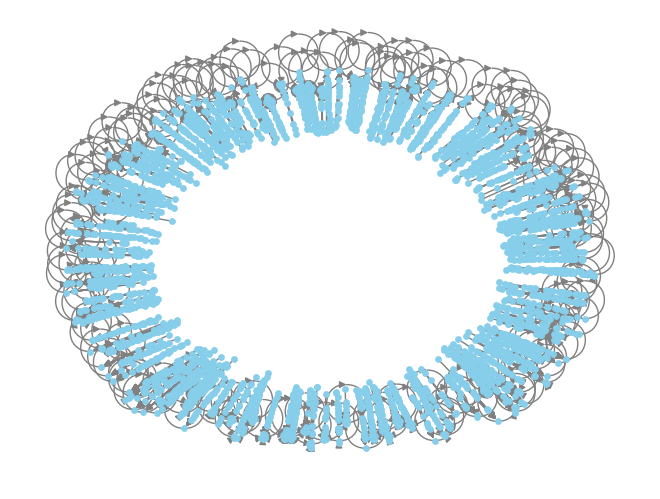

In [23]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=15, edge_color='gray')
plt.show()

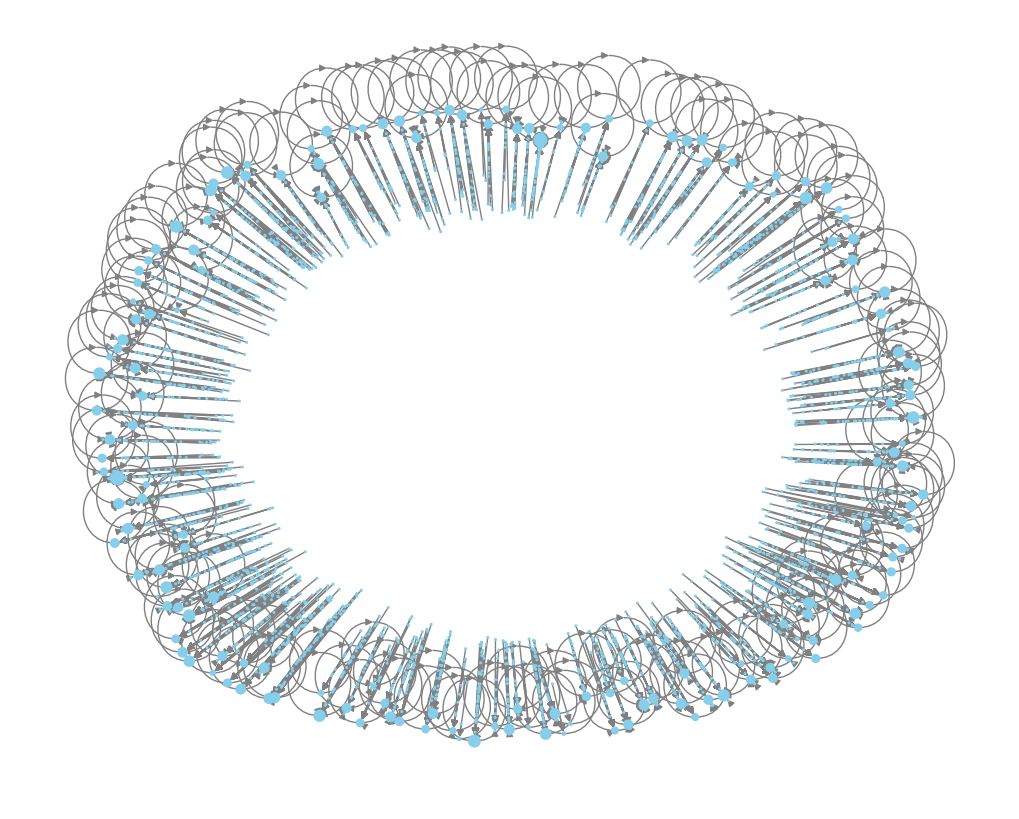

In [24]:
# Assuming G is your graph
degree_centrality = nx.degree_centrality(G)

# Draw the graph with node size proportional to degree centrality
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
node_size = [v * 6000 for v in degree_centrality.values()]
nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=node_size, edge_color='gray')
plt.show()

## Generating Node Embeddings

In [25]:
# Precompute probabilities and generate walks

node2vec = n2v(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 4172/4172 [00:00<00:00, 50268.85it/s]


## Storing Node Embeddings

In [32]:
# Extract embeddings for each node
embeddings = {str(node): model.wv[str(node)] for node in G.nodes()}

# Convert embeddings to DataFrame for better manipulation
embeddings_df = pd.DataFrame.from_dict(embeddings, orient='index')

In [33]:
embeddings_df.index = embeddings_df.index.astype(int)  # Convert index to int
embeddings_df.reset_index(inplace=True)
embeddings_df.columns = ['id_employee'] + [f'embedding_{i}' for i in range(embeddings_df.shape[1] - 1)]

In [34]:
embeddings_df

,id_employee,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63
0,100247,-0.001200,-0.006800,-0.001797,0.006557,-0.000795,-0.003192,-0.004008,0.001157,0.004892,...,-0.006522,0.006472,-0.002157,0.003665,-0.006457,0.001737,-0.002640,-0.004717,-0.001507,-0.000358
1,103355,-0.001369,-0.004692,-0.007678,0.001975,-0.000333,0.005143,-0.000249,0.006819,0.005416,...,-0.007016,-0.002541,0.002594,0.003732,-0.003985,0.000156,0.006782,0.003251,-0.006115,-0.001592
2,100669,0.006336,-0.005749,0.007707,0.007162,0.002057,0.000118,0.001787,-0.004974,0.001414,...,-0.007082,0.004071,-0.007691,-0.005843,-0.004542,-0.003720,-0.001474,0.003348,0.007664,0.000107
3,103760,-0.005489,0.003706,0.005784,-0.000779,0.002870,0.002429,0.005870,0.001188,-0.000664,...,0.007658,0.006651,0.001244,-0.007786,0.006929,0.004735,-0.007587,-0.005542,-0.007174,-0.000899
4,100965,-0.004639,0.005550,-0.007378,-0.005234,0.002110,-0.005844,-0.006749,-0.000599,-0.005708,...,0.005373,0.004535,-0.001359,-0.003321,-0.002662,0.004147,0.003077,0.007362,0.005644,-0.007722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4167,103755,0.003467,0.006605,-0.003180,0.001510,0.002173,-0.005795,-0.004909,0.003441,-0.004230,...,-0.007403,-0.000856,-0.003115,-0.007667,-0.005604,0.007295,0.000173,-0.000831,0.003166,-0.007124
4168,103976,-0.003778,-0.003320,-0.000755,-0.005284,0.000293,0.007593,0.005632,-0.004011,0.002961,...,0.002689,0.001099,0.004279,0.003994,0.006202,0.000198,0.005482,-0.007474,-0.003825,0.005676
4169,104115,-0.001796,0.003190,-0.004799,-0.000592,-0.000218,0.002816,0.007431,-0.002113,0.003260,...,0.001511,-0.000798,0.007683,0.000077,-0.003422,0.007190,0.000851,-0.000139,-0.002080,0.002548
4170,103920,0.006316,-0.005578,0.006928,0.000097,-0.002765,-0.001114,0.006769,0.006368,0.004472,...,-0.007052,0.000017,-0.007704,-0.006224,-0.001532,0.006456,0.001008,0.002195,-0.000352,-0.005870


## Merge node embeddings with original data

In [42]:
# Catching id_employee_employee embeddings

final_df = combined_df.merge(embeddings_df, on='id_employee', how='left')
final_df.columns = combined_df.columns.tolist() + [f'embedding_employee_{i}' for i in range(embeddings_df.shape[1] - 1)]
columns = final_df.columns.tolist()

# Catching id_boss_employee embeddings

final_df = final_df.merge(embeddings_df, left_on='id_last_boss', right_on='id_employee', how='left')
final_df.columns = columns + [f'embedding_boss_{i}' for i in range(embeddings_df.shape[1])]
final_df.drop(columns='embedding_boss_0', inplace=True)

In [47]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4172 entries, 0 to 4171
Columns: 174 entries, id_employee to embedding_boss_64
dtypes: float32(128), float64(9), int64(25), object(12)
memory usage: 3.5+ MB


## Split back into Train and Test DataFrames

In [48]:
train_new = final_df.loc[:len(train_df)-1,:].reset_index(drop=True)
test_new = final_df.loc[len(train_df):, :].reset_index(drop=True)

In [49]:
train_new = pd.concat([train_new, target], axis=1)

In [50]:
train_new

,id_employee,id_last_boss,seniority,work_modality,office_distance,low_health_days,gender,recruitment_channel,average_permanence,salary,...,embedding_boss_56,embedding_boss_57,embedding_boss_58,embedding_boss_59,embedding_boss_60,embedding_boss_61,embedding_boss_62,embedding_boss_63,embedding_boss_64,resign
0,100247,102074,1,Híbrida,1.760,1,Mujer,Ferias & Networking,1,140011,...,-0.510359,0.867795,-0.236739,-0.020616,2.016547,-1.538088,0.673502,-3.966547,0.690487,0
1,103355,102115,1,Híbrida,0.760,2,Hombre,Ferias & Networking,2,182774,...,0.099191,-1.411987,0.763236,-0.620354,3.045463,0.109220,2.197151,-2.345624,-2.300716,1
2,100669,102060,1,Híbrida,4.950,3,Mujer,Referidos,11,682106,...,0.476858,0.012612,-0.322904,-2.159082,0.858201,-0.037781,2.198319,-3.286139,0.638560,0
3,103760,102062,1,Híbrida,13.030,2,Hombre,Linkedin,2,270232,...,-0.502130,0.991737,-0.679418,-2.373596,2.779397,0.748496,-0.247417,-1.656327,-0.252358,1
4,100965,102062,1,Híbrida,13.045,2,Hombre,Linkedin,2,266804,...,-0.502130,0.991737,-0.679418,-2.373596,2.779397,0.748496,-0.247417,-1.656327,-0.252358,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,103567,102171,1,Presencial,1.965,8,Mujer,Portal Web,3,281159,...,-0.196705,-0.777604,-1.874209,-3.026742,3.315532,0.186572,1.629825,-2.550516,-1.192857,1
2148,104098,102172,1,Presencial,0.805,12,Mujer,Linkedin,13,460337,...,-0.182652,1.170694,0.491200,-1.659328,0.995259,-0.232451,0.376152,-3.619655,-1.564334,1
2149,103987,102155,1,Presencial,1.625,1,Hombre,Portal Web,11,633879,...,1.200129,-0.637064,-0.786244,-3.396498,1.790005,-1.436900,0.385597,-2.636923,-0.108442,1
2150,103810,102141,1,Presencial,5.665,2,Hombre,Portal Web,6,793977,...,0.358218,-0.413883,-1.762365,-1.915706,2.726416,0.027674,2.701519,-2.674003,-0.791803,1


In [51]:
test_new

,id_employee,id_last_boss,seniority,work_modality,office_distance,low_health_days,gender,recruitment_channel,average_permanence,salary,...,embedding_boss_55,embedding_boss_56,embedding_boss_57,embedding_boss_58,embedding_boss_59,embedding_boss_60,embedding_boss_61,embedding_boss_62,embedding_boss_63,embedding_boss_64
0,100486,102115,1,Híbrida,0.795,2,Hombre,Ferias & Networking,2,181654,...,-0.111634,0.099191,-1.411987,0.763236,-0.620354,3.045463,0.109220,2.197151,-2.345624,-2.300716
1,103752,102074,1,Híbrida,1.715,1,Mujer,Ferias & Networking,1,140986,...,-1.025180,-0.510359,0.867795,-0.236739,-0.020616,2.016547,-1.538088,0.673502,-3.966547,0.690487
2,103937,102150,1,Híbrida,2.375,1,Hombre,Portal Web,6,406690,...,-0.430835,-0.828899,1.165218,-2.244088,-1.897816,3.363254,-0.720202,1.520645,-4.255674,-1.495621
3,101744,102172,1,Híbrida,2.185,3,Hombre,Linkedin,3,249107,...,0.344714,-0.182652,1.170694,0.491200,-1.659328,0.995259,-0.232451,0.376152,-3.619655,-1.564334
4,101037,102060,1,Híbrida,4.660,3,Hombre,Referidos,10,698318,...,0.991722,0.476858,0.012612,-0.322904,-2.159082,0.858201,-0.037781,2.198319,-3.286139,0.638560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,103755,102161,1,Presencial,2.995,2,Mujer,Portal Web,16,700814,...,0.149485,0.366444,-0.653721,-1.055352,-1.036641,2.351889,-1.885075,0.253300,-1.522621,-1.607997
2016,103976,102171,1,Presencial,2.775,0,Mujer,Portal Web,5,677071,...,-0.109445,-0.196705,-0.777604,-1.874209,-3.026742,3.315532,0.186572,1.629825,-2.550516,-1.192857
2017,104115,102144,1,Presencial,3.990,1,Hombre,Portal Web,7,876285,...,1.424313,0.454429,-2.454625,-0.362413,-1.827920,2.274745,-0.146303,1.961531,-3.526861,-1.944221
2018,103920,102152,1,Presencial,7.100,1,Mujer,Linkedin,8,719102,...,-0.682296,0.316360,0.889524,-1.107746,-2.068202,3.200748,-1.198715,-0.088449,-4.003725,-0.507367


## Saving new DataFrames

In [52]:
train_new.to_csv(paths.data_interim_dir('train_node.csv'), index=False, sep=',')
test_new.to_csv(paths.data_interim_dir('test_node.csv'), index=False, sep=',')